In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
import random as rd

In [45]:
skip_idx = rd.sample(range(1, 1000000), 880000)

In [46]:
df_train_fp = pd.read_csv("f4ltrain.csv.gz", skiprows=skip_idx)
df_train_og = pd.read_csv("trainpgs.csv.gz", skiprows=skip_idx)

In [3]:
"""
Read in train and test as Pandas DataFrames
"""

#df_train_og = pd.read_csv("train.csv.gz")
#df_test_og = pd.read_csv("test.csv.gz")
df_test_fp = pd.read_csv("f4ltest.csv.gz")

#num_lines=1000000
#n = 50
#skip_idx = [x for x in range(1, num_lines) if x % n != 0]

df_test_og = pd.read_csv("testpgs.csv.gz")

In [ ]:
# TODO: MAKE SURE YOU DELETE FIRST COLUMN FROM f4ltrain and f41test

In [47]:
df_train = pd.concat([df_train_og,df_train_fp],axis=1)
#df_test = pd.concat([df_test_og,df_test_fp],axis=1)

In [48]:
df_train = df_train.drop("Unnamed: 0",axis=1)
#df_test = df_test.drop("Unnamed: 0",axis=1)

In [49]:
np.random.seed(9001)
msk = np.random.rand(len(df_train)) < 0.9
data_train = df_train[msk]
data_val = df_train[~msk]

In [27]:
Y_train = df_train.gap.values
X_train = df_train.drop(["gap","smiles"],axis=1)
X_test = df_test.drop(["Id","smiles"],axis=1)

### HP Graph

In [52]:
Y_train_hp = data_train.gap.values
X_train_hp = data_train.drop(["gap","smiles"],axis=1)
Y_val = data_val.gap.values
X_val = data_val.drop(["gap","smiles"],axis=1)

In [59]:
train_rmsle = []
val_rmsle = []
for mf in [.1,.3,.5,.7,.9]:
    RF_val = RandomForestRegressor(n_estimators=30, max_features=mf, n_jobs=-1)
    RF_val.fit(X_train_hp, Y_train_hp)
    RF_predtrainhp = RF_val.predict(X_train_hp)
    RF_predvalhp = RF_val.predict(X_val)
    train_rmsle.append(np.sqrt(np.sum(np.square(RF_predtrainhp - Y_train_hp))/RF_predtrainhp.shape[0]))
    val_rmsle.append(np.sqrt(np.sum(np.square(RF_predvalhp - Y_val))/RF_predvalhp.shape[0]))

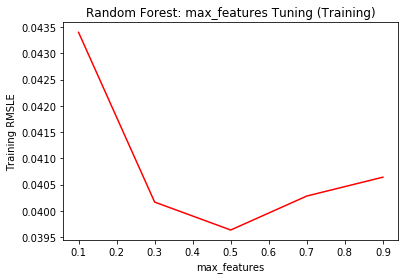

In [73]:
plt.plot([.1,.3,.5,.7,.9],train_rmsle,color="red")
plt.title("Random Forest: max_features Tuning (Training)")
plt.ylabel("Training RMSLE")
plt.xlabel("max_features")
plt.show()

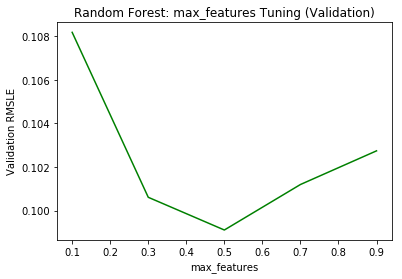

In [74]:
plt.plot([.1,.3,.5,.7,.9],val_rmsle,color="green")
plt.title("Random Forest: max_features Tuning (Validation)")
plt.ylabel("Validation RMSLE")
plt.xlabel("max_features")
plt.show()

### ElasticNet

In [30]:
# TODO: run
LR = RidgeCV(cv=10, alphas=[.05, .125, .5, 2], fit_intercept=True)
LR.fit(X_train, Y_train)
LR_pred = LR.predict(X_test)

/anaconda/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.77995794952885e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)
/anaconda/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.2119432484966175e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)
/anaconda/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 6.8952209999147066e-18
  ' condition number: {}'.format(rcond), RuntimeWarning)
/anaconda/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaran

In [31]:
"Train RMSLE: {}".format(np.sqrt(np.sum(np.square(LR.predict(X_train) - Y_train))/LR.predict(X_train).shape[0]))

'Train RMSLE: 0.15201597196621391'

In [32]:
LR.alpha_

2

### Random Forest

In [38]:
# DO NOT RUN
param_grid_rf = {'max_features': [.2,.4,.6], 'n_estimators': [25,50,75]}
from sklearn.model_selection import GridSearchCV
RF_forcv = RandomForestRegressor(n_jobs=1, max_depth = 3)
RF_cv = GridSearchCV(RF_forcv, param_grid_rf, cv=5, n_jobs=-1)
RF_cv.fit(X_train,Y_train)
RF_pred_cv = RF_cv.predict(X_test)

In [49]:
# DO NOT RUN
RF_cv.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features=0.6, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=75, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [15]:
# RUN
RF = RandomForestRegressor(n_estimators=250, max_features=.6, n_jobs=-1)
RF.fit(X_train, Y_train)
RF_predtrain = RF.predict(X_train)

In [16]:
"Train RMSLE: {}".format(np.sqrt(np.sum(np.square(RF_predtrain - Y_train))/RF_predtrain.shape[0]))

'Train RMSLE: 0.03711864083316527'

In [17]:
RF_pred = RF.predict(X_test)

### AdaBoost

In [39]:
# TODO: Run
param_grid_rf = {'n_estimators': [175,250], 'learning_rate': [.12,.2]}

from sklearn.model_selection import GridSearchCV
AB_base = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=3))
AB_cv = GridSearchCV(AB_base, param_grid_rf, cv=5, n_jobs=-1)
AB_cv.fit(X_train,Y_train)
AB_pred_cv = AB_cv.predict(X_test)

In [45]:
AB_cv.best_estimator_

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
         learning_rate=0.2, loss='linear', n_estimators=75,
         random_state=None)

In [42]:
ABcv_predtrain = AB_cv.predict(X_train)

In [44]:
"Train RMSLE: {}".format(np.sqrt(np.sum(np.square(ABcv_predtrain - Y_train))/ABcv_predtrain.shape[0]))

'Train RMSLE: 0.2928110157168813'

In [34]:
AB=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=10),
                            n_estimators=15, learning_rate = 0.3)
AB.fit(X_train,Y_train)
AB_predtrain = AB.predict(X_train)

In [35]:
"Train RMSLE (ABR): {}".format(np.sqrt(np.sum(np.square(AB_predtrain - Y_train))/AB_predtrain.shape[0]))

'Train RMSLE (ABR): 0.22965460186034856'

In [36]:
AB_pred = AB.predict(X_test)

 ### Neural Net

### File Writing

In [18]:
def write_to_file(filename, predictions):
    with open(filename, "w") as f:
        f.write("Id,Prediction\n")
        for i,p in enumerate(predictions):
            f.write(str(i+1) + "," + str(p) + "\n")

In [33]:
write_to_file("sample1mk_ridge.csv", LR_pred)
#write_to_file("sample2nmk.csv", RF_pred)